# **PROJET 06 : Classifiez automatiquement des biens de consommation**

# Sommaire :  

[1/ Introduction](#In)

[2/ Préparation des données](#Pr)

[3/ Traitements de textes : TF IDF](#Txt)

[4/ Traitements de textes : Bag of Words](#Txt2)

[5/ Réduction de Dimensions LDA](#LDA)

[6/ Réduction de Dimensions PCA et KMeans](#PCA)

[7/ Réduction de Dimensions TSNE et Kmeans](#TSNE)

[8/ Traitements de textes : Word2Vec ](#W)

[9/ Traitements de textes : BERT ](#BERT)



<a name="In"></a>
## **1/Introduction** 

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.

Il nous est demandé d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.


### Précision :

Dans ce projet nous allons utiliser le [NLP](https://datascientest.com/introduction-au-nlp-natural-language-processing).

Le NLP, ou Natural Language Processing, est une discipline qui porte essentiellement sur la compréhension, la manipulation et la génération du langage naturel par les machines.  Ainsi, le NLP est réellement à l’interface entre la science informatique et la linguistique. Il porte donc sur la capacité de la machine à interagir directement avec l’humain.

Dans ce projet, nous allons suivre le processus suivant : 

- Extraction des features
- Réduction de dimensions
- Clustering


Voici les 4 approches pour extraire les features :

- Bag of Word
- Topics modeling on a bag of word
-  Wiki2vec Word embedding
-  Universal Sentence Encoder

Pour chaque approche nous allons utiliser GridSearch afin d'utiliser les meilleurs hyperparamètres possibles.


Voici une image qui décrit l'ensemble du procédé en NLP

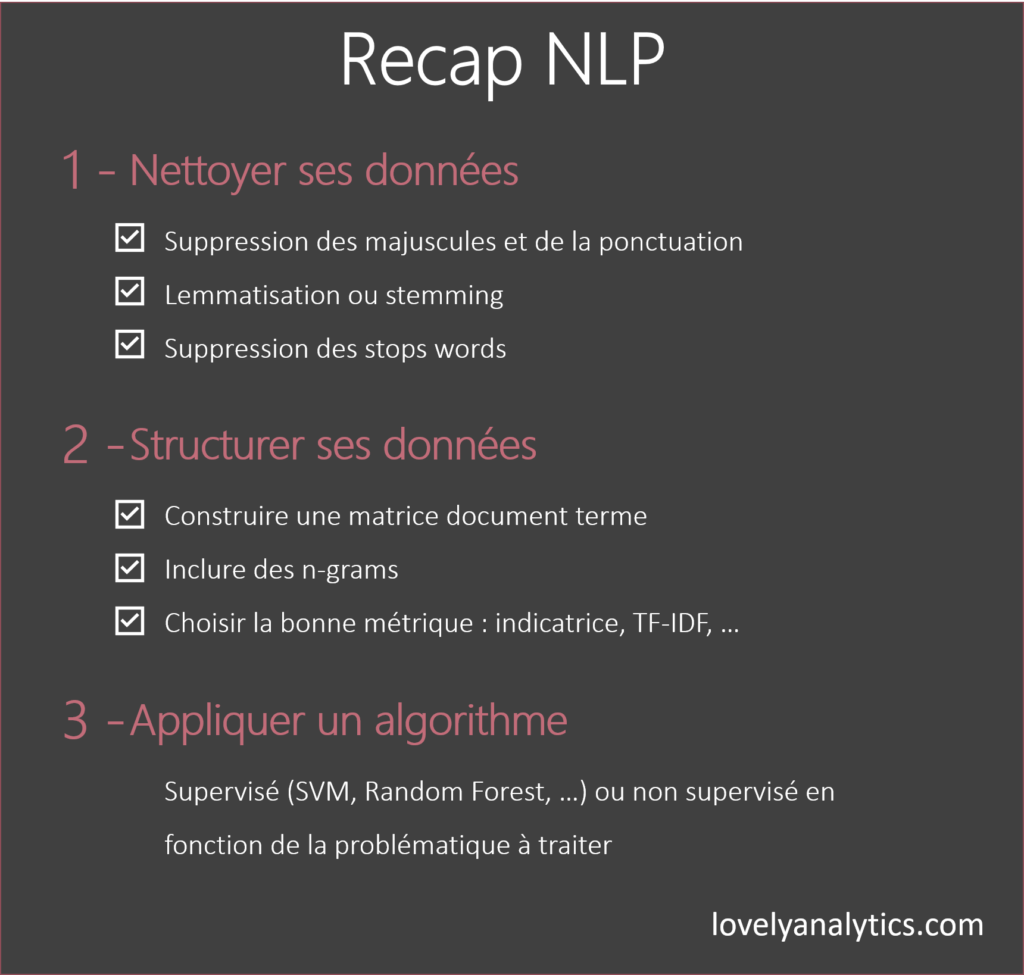

<a name="Pr"></a>
## **2/ Préparation des données**  

### Import des librairies

In [ ]:
from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
import time
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [ ]:
!pip install opencv-contrib-python
!pip install tensorflow

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf


pd.options.display.max_rows = 999

from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model

from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
from IPython.display import Image

from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Fonctions utilisées :     



In [ ]:
def reduction_memoire(df):
    """ itère à travers les colonnes du dataframe et réduit l'usage de la mémoire       
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """crée un Dataframe en optimisant son usage de mémoire"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [ ]:
#Traitement des catégories
def separation(category, level):
    '''Fonction qui affiche les '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def separation_1(category):
    return separation(category,0)
def separation_2(category):
    return separation(category,1)
def separation_3(category):
    return separation(category,2)

def detail_categories(dataframe):
    dataframe['cat_lvl_1'] = dataframe['product_category_tree'].apply(separation_1)
    dataframe['cat_lvl_2'] = dataframe['product_category_tree'].apply(separation_2)
    dataframe['cat_lvl_3'] = dataframe['product_category_tree'].apply(separation_3)
    return dataframe.drop(['product_category_tree'], axis=1)

## Import des images 

In [ ]:
use_colab = True 

if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path ='/content/drive/MyDrive/'
else:
    path='/data/'

images = [cv2.imread(file) for file in glob.glob(path + "Images/*.jpg")]
len(images)

Mounted at /content/drive


1050

In [ ]:
from IPython.display import Image

images_list =[Image(file) for file in glob.glob(path + "Images/*.jpg")]
len(images_list)

1050

## Import du Dataframe

In [ ]:
data = pd.read_csv(path + 'flipkart_com-ecommerce_sample_1050.csv')


In [ ]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

On observe que dans la colonne "Category_tree" , on a trois types de catégories de produits dans la même colonne.

On va donc faire une séparation de cette colonne en trois colonnes , chaque colonne étant un type de catégorie.

In [ ]:
data = detail_categories(data)

In [ ]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_lvl_1,cat_lvl_2,cat_lvl_3
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets


In [ ]:
for col in data[['cat_lvl_1','cat_lvl_2','cat_lvl_3']]:

    data_copy = data.groupby(col).count()['uniq_id'].sort_values(ascending=False)
    display(data_copy)

cat_lvl_1
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

cat_lvl_2
Wrist Watches                      149
Laptop Accessories                  87
Infant Wear                         84
Coffee Mugs                         74
Showpieces                          71
Bed Linen                           65
Fragrances                          65
Network Components                  49
Cookware                            27
Table Decor & Handicrafts           27
Combos and Kits                     24
Wall Decor & Clocks                 22
Bath Linen                          21
Curtains & Accessories              19
Makeup                              18
Baby & Kids Gifts                   15
Body and Skin Care                  15
Baby Bedding                        15
Baby Bath & Skin                    14
Decorative Lighting & Lamps         14
Kitchen Tools                       14
Kitchen & Dining Linen              14
Containers & Bottles                13
Cushions, Pillows & Covers          13
Hair Care                            9
Feeding & Nursi

cat_lvl_3
Deodorants                                             65
Blankets, Quilts & Dohars                              57
Baby Girls' Clothes                                    49
Routers                                                49
USB Gadgets                                            38
Baby Boys' Clothes                                     35
Ethnic                                                 34
Prithish Coffee Mugs                                   26
Pots & Pans                                            24
Maxima Wrist Watches                                   23
Showpieces                                             23
Rockmantra Coffee Mugs                                 22
Batteries                                              22
Sonata Wrist Watches                                   19
Curtains                                               19
Towels                                                 19
Printland Coffee Mugs                                  13
Kitc

In [ ]:
data.to_csv('data_categories.csv',sep=',',index = True)

On affiche le nombre d'utilisateurs appartenant à chaque catégorie. La répartition des utilisateurs étant égale dans la Catégorie 1, on s'intéresse à sa sous-catégorie, la Catégorie 2.

Pour rappel :

La Catégorie 3 est incluse dans la Catégorie 2.

La Catégorie 2 est incluse dans la Catégorie 1.




Dans la Catégorie 2, on observe que la majorité des achats sont des montres.

In [ ]:
#Identification des catégories les plus représentées
occurence_cat_2 = pd.DataFrame(data['cat_lvl_2'].value_counts())
occurence_cat_2.head()

,cat_lvl_2
Wrist Watches,149
Laptop Accessories,87
Infant Wear,84
Coffee Mugs,74
Showpieces,71


In [ ]:
#identification des catégories pour lesquelles on a le moins d'occurence
cat_to_fill = occurence_cat_2[occurence_cat_2['cat_lvl_2'] < 10]
cat_to_fill.sample(5)

,cat_lvl_2
Dinnerware & Crockery,1
Eye Care,2
Women's Hygiene,1
Housekeeping & Laundry,1
Garden & Leisure,1


<a name="Txt"></a>
## **3/ Traitement de textes : TF IDF**  

## Traitement des descriptions des produits 

In [ ]:
data["texte"] = data["product_name"].map(str) + " " + data["description"]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   pid                      1050 non-null   object 
 5   retail_price             1049 non-null   float64
 6   discounted_price         1049 non-null   float64
 7   image                    1050 non-null   object 
 8   is_FK_Advantage_product  1050 non-null   bool   
 9   description              1050 non-null   object 
 10  product_rating           1050 non-null   object 
 11  overall_rating           1050 non-null   object 
 12  brand                    712 non-null    object 
 13  product_specifications   1049 non-null   object 
 14  cat_lvl_1               

In [ ]:
data.info()
data_embedding = data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   pid                      1050 non-null   object 
 5   retail_price             1049 non-null   float64
 6   discounted_price         1049 non-null   float64
 7   image                    1050 non-null   object 
 8   is_FK_Advantage_product  1050 non-null   bool   
 9   description              1050 non-null   object 
 10  product_rating           1050 non-null   object 
 11  overall_rating           1050 non-null   object 
 12  brand                    712 non-null    object 
 13  product_specifications   1049 non-null   object 
 14  cat_lvl_1               

In [ ]:
data_embedding.to_csv("/content/drive/MyDrive/data_embedding.csv")

In [ ]:
data[['texte']].head()

,texte
0,Elegance Polyester Multicolor Abstract Eyelet ...
1,Sathiyas Cotton Bath Towel Specifications of S...
2,Eurospa Cotton Terry Face Towel Set Key Featur...
3,SANTOSH ROYAL FASHION Cotton Printed King size...
4,Jaipur Print Cotton Floral King sized Double B...


Traitement TF IDF :      

[TF IDF](https://fr.acervolima.com/comprendre-tf-idf-frequence-de-terme-frequence-de-document-inverse/) est une méthode de pondération.

Il est défini comme le calcul de la pertinence d’un mot d’une série ou d’un corpus par rapport à un texte. Le sens augmente proportionnellement au nombre de fois qu’un mot apparaît dans le texte mais est compensé par la fréquence du mot dans le corpus (data-set). 

Tf-idf est l’une des meilleures métriques pour déterminer l’importance d’un terme pour un texte d’une série ou d’un corpus. tf-idf est un système de pondération qui attribue un poids à chaque mot d’un document en fonction de sa fréquence de terme (tf) et de la fréquence de document réciproque (tf) (idf). Les mots avec des scores de poids plus élevés sont considérés comme plus significatifs.

Les [stopwords](https://pythonspot.com/nltk-stop-words/#:~:text=The%20stopwords%20in%20nltk%20are,nltk.tokenize%20import%20sent_tokenize%2C%20word_tokenize) correspondent aux mots les plus utilisés en data et qui ne nous seront pas utiles pour décrire notre jeu de données, les stopwords comprennent aussi les ponctuations.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from string import punctuation
from nltk.corpus import stopwords
stopwords_en = set(["a","a's","able","about","above","according","accordingly",
                    "across","actually","after","afterwards","again","against",
                    "ain't","all","allow","allows","almost","alone","along",
                    "already","also","although","always","am","among","amongst"
                    ,"an","and","another","any","anybody","anyhow","anyone",
                    "anything","anyway","anyways","anywhere","apart","appear",
                    "appreciate","appropriate","are","aren't","around","as",
                    "aside","ask","asking","associated","at","available","away",
                    "awfully","b","be","became","because","become","becomes",
                    "becoming","been","before","beforehand","behind","being",
                    "believe","below","beside","besides","best","better",
                    "between","beyond","both","brief","but","by","c","c'mon",
                    "c's","came","can","can't","cannot","cant","cause","causes",
                    "certain","certainly","changes","clearly","co","com","come",
                    "comes","concerning","consequently","consider","considering",
                    "contain","containing","contains","corresponding","could",
                    "couldn't","course","currently","d","definitely","described",
                    "despite","did","didn't","different","do","does","doesn't",
                    "doing","don't","done","down","downwards","during","e",
                    "each","edu","eg","eight","either","else","elsewhere",
                    "enough","entirely","especially","et","etc","even","ever",
                    "every","everybody","everyone","everything","everywhere",
                    "ex","exactly","example","except","f","far","few","fifth",
                    "first","five","followed","following","follows","for",
                    "former","formerly","forth","four","from","further",
                    "furthermore","g","get","gets","getting","given","gives",
                    "go","goes","going","gone","got","gotten","greetings","h",
                    "had","hadn't","happens","hardly","has","hasn't","have",
                    "haven't","having","he","he's","hello","help","hence","her",
                    "here","here's","hereafter","hereby","herein","hereupon",
                    "hers","herself","hi","him","himself","his","hither",
                    "hopefully","how","howbeit","however","i","i'd","i'll",
                    "i'm","i've","ie","if","ignored","immediate","in",
                    "inasmuch","inc","indeed","indicate","indicated","indicates",
                    "inner","insofar","instead","into","inward","is","isn't",
                    "it","it'd","it'll","it's","its","itself","j","just","k",
                    "keep","keeps","kept","know","known","knows","l","last",
                    "lately","later","latter","latterly","least","less","lest",
                    "let","let's","like","liked","likely","little","look",
                    "looking","looks","ltd","m","mainly","many","may","maybe",
                    "me","mean","meanwhile","merely","might","more","moreover",
                    "most","mostly","much","must","my","myself","n","name",
                    "namely","nd","near","nearly","necessary","need","needs",
                    "neither","never","nevertheless","new","next","nine","no",
                    "nobody","non","none","noone","nor","normally","not",
                    "nothing","novel","now","nowhere","o","obviously","of","off",
                    "often","oh","ok","okay","old","on","once","one","ones",
                    "only","onto","or","other","others","otherwise","ought",
                    "our","ours","ourselves","out","outside","over","overall",
                    "own","p","particular","particularly","per","perhaps",
                    "placed","please","plus","possible","presumably","probably",
                    "provides","q","que","quite","qv","r","rather","rd","re",
                    "really","reasonably","regarding","regardless","regards",
                    "relatively","respectively","right","s","said","same","saw",
                    "say","saying","says","second","secondly","see","seeing",
                    "seem","seemed","seeming","seems","seen","self","selves",
                    "sensible","sent","serious","seriously","seven","several",
                    "shall","she","should","shouldn't","since","six","so",
                    "some","somebody","somehow","someone","something",
                    "sometime","sometimes","somewhat","somewhere","soon",
                    "sorry","specified","specify","specifying","still","sub",
                    "such","sup","sure","t","t's","take","taken","tell","tends",
                    "th","than","thank","thanks","thanx","that","that's",
                    "thats","the","their","theirs","them","themselves","then",
                    "thence","there","there's","thereafter","thereby",
                    "therefore","therein","theres","thereupon","these","they",
                    "they'd","they'll","they're","they've","think","third",
                    "this","thorough","thoroughly","those","though","three",
                    "through","throughout","thru","thus","to","together","too",
                    "took","toward","towards","tried","tries","truly","try",
                    "trying","twice","two","u","un","under","unfortunately",
                    "unless","unlikely","until","unto","up","upon","us","use",
                    "used","useful","uses","using","usually","uucp","v","value",
                    "various","very","via","viz","vs","w","want","wants","was",
                    "wasn't","way","we","we'd","we'll","we're","we've",
                    "welcome","well","went","were","weren't","what","what's",
                    "whatever","when","whence","whenever","where","where's",
                    "whereafter","whereas","whereby","wherein","whereupon",
                    "wherever","whether","which","while","whither","who",
                    "who's","whoever","whole","whom","whose","why","will",
                    "willing","wish","with","within","without","won't","wonder",
                    "would","wouldn't","x","y","yes","yet","you","you'd",
                    "you'll","you're","you've","your","yours","yourself",
                    "yourselves","z","zero"])

La librairie NLTK nous sert à analyser et surtout exploiter des données textuelles. On installe la librairie et toutes ses fonctions.

In [ ]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stopwords_combined = set.union(stopwords_en, stopwords_nltk, stopwords_punct)

In [ ]:
print('ponctuation : ',list(stopwords_punct)[0:4])
print('stopwords : ',list(stopwords_nltk)[0:4])

ponctuation :  [';', '$', '=', '<']
stopwords :  ['during', 'between', 'yours', 'so']


On effectue une [tokenization](https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/) , elle consiste à séparer un bout de texte en plusieurs segments appelés tokens. Les tokens sont des caractères, des ponctuations, ou des chaines de caractères qui sont en fait des sous-mots ( n-grams caractères ).


La [lemmatization](https://www.engati.com/glossary/lemmatization) consiste à regrouper ensemble toutes les formes d'un mot (pluriel, féminin, masculin) et de le raccorder à sa forme la plus basique pour l'utiliser dans du Machine Learning. Un exemple avec l'image ci-dessous

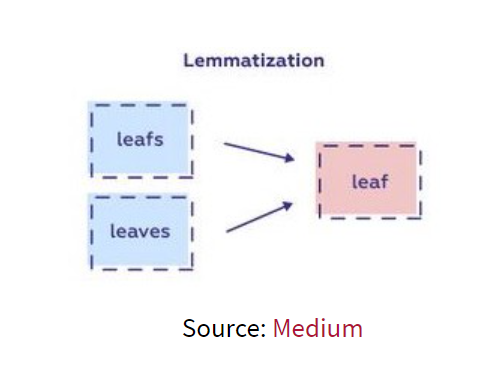

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
     def __init__(self):
         self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

tfidf = TfidfVectorizer(encoding='utf-8',
                       lowercase=True,
                       tokenizer=LemmaTokenizer(),
                       stop_words=stopwords_combined,
                       )

In [ ]:
nltk.download('punkt')

nltk.download('wordnet')

nltk.download('omw-1.4')

tfidf.fit_transform(data['texte'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", '``', 'ai', 'ca', 'change', 'doe', 'give', 'greeting', 'ha', 'le', "n't", 'regard', 'sha', 'wa', 'wo'] not in stop_words.
  % sorted(inconsistent)


<1050x5903 sparse matrix of type '<class 'numpy.float64'>'
	with 35327 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


["''",
 "'m",
 "'re",
 "'s",
 "'smart",
 "'ve",
 '+60c',
 '+70c',
 ',bela',
 ',specifications',
 '--',
 '-1001',
 '-15',
 '-20',
 '-200',
 '-20c-',
 '-23',
 '-300',
 '-30c',
 '-4',
 '-a',
 '-age',
 '-available',
 '-avoid',
 '-blue',
 '-includes',
 '-keeps',
 '-large',
 '-material',
 '-one',
 '-reusable',
 '-sizes',
 '-snap',
 '-trim',
 '-tumble',
 '-wash',
 '..',
 '...',
 '.....',
 '...................',
 '......................',
 '.237',
 '.25-2.5',
 '.5',
 '.5-3.5',
 '.dry',
 '.frill',
 '.please',
 '//',
 '//storage',
 '/dust',
 '/pot',
 '0',
 '0.0',
 '0.04',
 '0.2',
 '0.281',
 '0.45lbs',
 '0.5',
 '0.500',
 '0.7',
 '0.750ml',
 '0.92',
 '001',
 '006',
 '01',
 '01433cmgy',
 '01727lpln',
 '01741lpln',
 '01784bmly',
 '03918cmly',
 '04615cmgy',
 '05712lmly',
 '05tg-166-24-raw',
 '05tg-870-20-n.blue',
 '05tg-870-26-antra',
 '06',
 '06,22',
 '06362cmgy',
 '07034lmli',
 '09321cmgy',
 '1',
 '1,052',
 '1,064',
 '1,085',
 '1,099',
 '1,100',
 '1,112',
 '1,145',
 '1,199',
 '1,200',
 '1,240',
 '1

In [ ]:
matrix_func = tfidf.transform(data['texte'])

In [ ]:
matrix_func

<1050x5903 sparse matrix of type '<class 'numpy.float64'>'
	with 35327 stored elements in Compressed Sparse Row format>

In [ ]:
matrix_func.todense()[0,:].tolist()

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [ ]:
data['texte'].iloc[0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

On effectue ici la tokenization, la lemmatisation et transformation TF IDF

In [ ]:
from nltk import word_tokenize
def affiche_liste(liste):
    return liste

description_example = data['texte'].iloc[4]
print('======== PRE TRAITEMENT ========')
print(affiche_liste(description_example),'\n')
#lowercase
description_example = description_example.lower()
print('======== LOWERCASE ========')
print(affiche_liste(description_example),'\n')

#tokenizer
description_example = word_tokenize(description_example)
print('======== TOKENIZER ========')
print(affiche_liste(description_example),'\n')


#stopwords
description_example = [w for w in description_example if not w in stopwords_combined] 
print('======== STOPWORDS ========')
print(affiche_liste(description_example),'\n')

#lemmatizer
lemm = WordNetLemmatizer()
description_example = [lemm.lemmatize(el) for el in description_example]
print('======== LEMMATISATION ========')
print(affiche_liste(description_example),'\n')

transformation = []
for i, el  in enumerate(matrix_func.todense()[4,:].tolist()[0]):
    if el !=0:
        transformation.append((tfidf.get_feature_names()[i], el))
pd.DataFrame(transformation, columns=['mot', 'tfidf']).sort_values(by='tfidf', ascending=False).head(10)

======== PRE TRAITEMENT ========
Jaipur Print Cotton Floral King sized Double Bedsheet Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) Price: Rs. 998 This nice bed sheet made up of 100% cotton to give you comfort. This bed sheet is hand printed. This bedsheet gives nice look to your room And its fast colour and good quality gives this bedsheet long life.,Specifications of Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) General Machine Washable Yes Brand Jaipur Print Type Flat Model Name jaipur117 Material Cotton Thread Count 140 Model ID jaipur117 Fabric Care machinewash, do not bleach Size King Color White Warranty waranty of the product only for manufacturing defect only and product will exchange onle when it is not used and returne its origional packing Dimensions Flat Sheet Width 86 inch / 220 cm Fitted Sheet Width 0 c

,mot,tfidf
75,sheet,0.453707
17,bedsheet,0.276758
47,jaipur,0.257108
50,king,0.230632
66,pillow,0.227463
77,sized,0.217198
16,bed,0.212208
39,flat,0.187244
27,cotton,0.185477
22,cm,0.183002


Ici on voit l'intéret de TF IDF qui, au lieu de retourner un booléan pour caractériser la présence d'un mot ( 1 pour Oui, 0 pour Non) , nous retourne un coefficient qui permet de quantifier la présence d'un mot dans notre jeu de données de manière plus précise.

Ici le mot le plus présent est "sheet"

<a name="Txt2"></a>
## **4/ Traitement de textes : Bag of Words**  

Le traitement [Bag of Words](https://datacorner.fr/bag-of-words/) consiste principalement à nettoyer les données textuelles à notre disposition d’une certaine manière afin de pouvoir ensuite les fournir en entrée de modèles d’apprentissage automatique.

  Il se résume en 3 phases :

- La décomposition des mots. On appelle cela aussi la tokenisation.

- La constitution d’un dictionnaire global qui sera en fait le vocabulaire.

- L’encodage des chaînes de caractère par rapport au vocabulaire constitué      précédemment.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(encoding='utf-8',
                       lowercase=True,
                       tokenizer=LemmaTokenizer(),
                       stop_words=stopwords_combined)

tf = tf_vectorizer.fit_transform(data['texte'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", '``', 'ai', 'ca', 'change', 'doe', 'give', 'greeting', 'ha', 'le', "n't", 'regard', 'sha', 'wa', 'wo'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
tf

<1050x5903 sparse matrix of type '<class 'numpy.int64'>'
	with 35327 stored elements in Compressed Sparse Row format>

In [ ]:
tf_bis = tf_vectorizer.fit_transform(data['texte'])

<a name="FDA"></a>
## **5/Réduction de dimensions LDA** 

Ici on va effectuer des [réductions de dimensions](http://cs229.stanford.edu/proj2017/final-reports/5163902.pdf) sur notre jeu de données, voici l'explication :     

Les mots très fréquents ne sont pas intéressants pour nos analyses. On a  supprimé les stop words mais il se peut qu’il y ait des mots fréquents liés au domaine analysé. De même, les mots très rares ne sont pas non plus intéressants.
Dans ce cas, on effectue une réduction de dimension.



Les méthodes principales de réduction de dimensionnalité en algèbre linéaire sont:

PCA (Principal Component Analysis): qui consiste à transformer des variables corrélées en nouvelles variables décorrélées en projetant les données dans le sens de la variance croissante. Les variables avec la variance maximale sont les composants principaux.

LDA (Linear Discriminant Analysis): il s’agit d’expliquer et de prédire l’appartenance d’une observation à une classe prédéfinie à partir des caractéristiques des variables prédictives. Cette méthode projette les données de manière à maximiser la séparabilité des classes et donc à minimiser la variance. Ce qui fait que les exemples de la même classe sont rassemblés par la projection tandis que les exemples de différentes classes sont éloignés.

Dans ce cas, nous avons des matrices avec des topics pour chaque document et une distribution des mots dans chaque topic.

Commencons avec LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
data['cat_lvl_1'].nunique()

7

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
   # print()

In [ ]:
lda = LatentDirichletAllocation(n_components = data['cat_lvl_1'].nunique(),
                               random_state=2)

lda.fit(tf)


tf_feature_names = tf_vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
tf_vectorizer.transform(data['texte'])

<1050x5903 sparse matrix of type '<class 'numpy.int64'>'
	with 35327 stored elements in Compressed Sparse Row format>

In [ ]:
lda.transform(tf_vectorizer.transform(data['texte']))

array([[9.94489427e-01, 9.19260506e-04, 9.19100600e-04, ...,
        9.19988227e-04, 9.16815059e-04, 9.16606002e-04],
       [4.06973028e-01, 2.04290033e-03, 2.89383254e-01, ...,
        2.04526165e-03, 2.04557081e-03, 3.52497070e-02],
       [3.58876123e-01, 8.57939094e-04, 2.20354523e-01, ...,
        8.57797571e-04, 8.59084875e-04, 2.30153161e-01],
       ...,
       [3.66437876e-03, 2.90073095e-01, 4.53760971e-01, ...,
        3.67136425e-03, 3.66419857e-03, 3.67415410e-03],
       [4.76418006e-03, 4.78261226e-03, 4.76923482e-03, ...,
        4.76286014e-03, 4.76379254e-03, 5.36276515e-01],
       [5.29249750e-03, 6.16811948e-01, 5.29833280e-03, ...,
        5.29410150e-03, 5.29303251e-03, 5.30996746e-03]])

In [ ]:
lda.transform(tf_vectorizer.transform(data['texte'])).shape

(1050, 7)

**Topics les plus représentés** :

In [ ]:
val_best_topic = {}
best_topic = {}
matrix = lda.transform(tf_vectorizer.transform(data['texte']))
for i in range(0,matrix.shape[0]):
    val_best_topic[i] = 0
    for j in range(0, matrix.shape[1]):
        if matrix[i,j] > val_best_topic[i]:
            val_best_topic[i] = matrix[i,j]
            best_topic[i]= j

In [ ]:
data_lda = data.copy()
data_lda['topic_lda'] = list(best_topic.values())

In [ ]:
data_lda[['cat_lvl_1','cat_lvl_2','topic_lda']].groupby(['topic_lda','cat_lvl_2']).count().sort_values(by=['topic_lda', 'cat_lvl_1'],ascending=[True, False])

cat_lvl_1
topic_lda cat_lvl_2                                 
0         Infant Wear                             84
          Coffee Mugs                             41
          Curtains & Accessories                  19
          Kitchen & Dining Linen                   9
          Baby Bedding                             8
          Wall Decor & Clocks                      8
          Bed Linen                                6
          Cushions, Pillows & Covers               6
          Floor Coverings                          6
          Laptop Accessories                       6
          Table Decor & Handicrafts                5
          Baby Bath & Skin                         3
          Flowers, Plants & Vases                  3
          Showpieces                               3
          Baby & Kids Gifts                        2
          Baby Grooming                            2
          Bath Linen                               2
          Decorative Lighting & Lamps              2
          Hair Care                                2
          Living                                   2
          Living Room Furnishing                   2
          Makeup                                   2
          Clocks                                   1
          Cookware                                 1
          Diapering & Potty Training               1
          Dinnerware & Crockery                    1
          Health Care                              1
          Housekeeping & Laundry                   1
          JMD Home Furnishing                      1
          Kitchen Tools                            1
          Kripa's Home Furnishing                  1
          Religion & Devotion                      1
          Showpiece                                1
          Tableware & Cutlery                      1
          Tidy Home Furnishing                     1
          Wrist Watches                            1
1         Fragrances                              61
          Bed Linen                               48
          Network Components                      32
          Laptop Accessories                      24
          Cookware                                11
          Wrist Watches                           11
          Body and Skin Care                      10
          Cushions, Pillows & Covers               7
          Makeup                                   7
          Baby Bedding                             5
          Coffee Mugs                              5
          Lighting                                 5
          Baby & Kids Gifts                        3
          Baby Bath & Skin                         3
          Bath and Spa                             3
          Bath Linen                               2
          Containers & Bottles                     2
          Diapering & Potty Training               2
          Feeding & Nursing                        2
          Furniture & Furnishings                  2
          Kitchen Tools                            2
          Laptops                                  2
          Showpieces                               2
          Baby Grooming                            1
          Bar & Glassware                          1
          Candles & Fragrances                     1
          Computer Peripherals                     1
          Decorative Lighting & Lamps              1
          Health Care                              1
          Men's Grooming                           1
          Pressure Cookers & Pans                  1
          Religion & Devotion                      1
          Software                                 1
          Table Decor & Handicrafts                1
          Wall Decor & Clocks                      1
2         Showpieces                              31
          Coffee Mugs                             25
          Bath Linen                              13
          Table

On a des topics qui sont homogènes avec aucune catégorie qui se dégage et des topics avec une catégorie clairement dominante. On a peu de données et beaucoup de catégories, ce qui explique cette répartition.

Topics identifiés en fonction de la catégorie du jeu de données :

In [ ]:
data_lda[['cat_lvl_1','cat_lvl_2','topic_lda']].groupby(['cat_lvl_2','topic_lda']).count().sort_values(by=['cat_lvl_2', 'cat_lvl_1'],ascending=[True, False])

cat_lvl_1
cat_lvl_2                       topic_lda           
Baby & Kids Gifts               6                  5
                                1                  3
                                3                  3
                                0                  2
                                2                  1
                                4                  1
Baby Bath & Skin                2                  5
                                0                  3
                                1                  3
                                3                  1
                                4                  1
                                6                  1
Baby Bedding                    0                  8
                                1                  5
                                3                  2
Baby Grooming                   0                  2
                                1                  1
                                4                  1
Bar & Glassware                 3                  3
                                4                  2
                                1                  1
                                2                  1
                                5                  1
Bath Linen                      2                 13
                                3                  3
                                0                  2
                                1                  2
                                6                  1
Bath and Spa                    1                  3
                                3                  3
                                5                  1
Beauty Accessories              4                  1
Bed Linen                       1                 48
                                0                  6
                                2                  6
                                4                  3
                                3                  2
Body and Skin Care              1                 10
                                6                  5
Candles & Fragrances            1                  1
Clocks                          0                  1
Coffee Mugs                     0                 41
                                2                 25
                                1                  5
                                6                  2
                                4                  1
Combos and Kits                 6                 11
                                2                  7
                                3                  3
                                5                  3
Computer Components             3                  2
Computer Peripherals            1                  1
                                3                  1
                                4                  1
                                5                  1
Consumables & Disposables       3                  1
Containers & Bottles            3                 11
                                1                  2
Cookware                        1                 11
                                6                  8
                                4                  3
                                3                  2
                                0                  1
                                2                  1
                                5                  1
Curtains & Accessories          0                 19
Cushions, Pillows & Covers      1                  7
                                0                  6
Decorative Lighting & Lamps     4                  4
                                3                  3
                                6                  3
                                0                  2
                                1                  1
                                2                  1
Diapering & Pot

<a name="PCA"></a>
## **5/Réduction de dimensions PCA et KMeans** 

[PCA (Principal Component Analysis)](https://www.invivoo.com/reduction-dimensionnalite-machine-learning/#:~:text=Les%20m%C3%A9thodes%20principales%20de%20r%C3%A9duction,sens%20de%20la%20variance%20croissante.) consiste à transformer des variables corrélées en nouvelles variables décorrélées en projetant les données dans le sens de la variance croissante. Les variables avec la variance maximale sont les composants principaux.

In [ ]:
X = data.copy()
X_bis=data.copy()

In [ ]:
from sklearn.decomposition import PCA
X = tf_vectorizer.transform(X['texte']).todense()
X_bis = tf_vectorizer.transform(X_bis['texte']).todense()

In [ ]:
ss_nlp = StandardScaler()
X = ss_nlp.fit_transform(X)
X_bis = ss_nlp.fit_transform(X_bis)
pca = PCA()
pca.fit(X)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

PCA()

In [ ]:
PCA()

PCA()

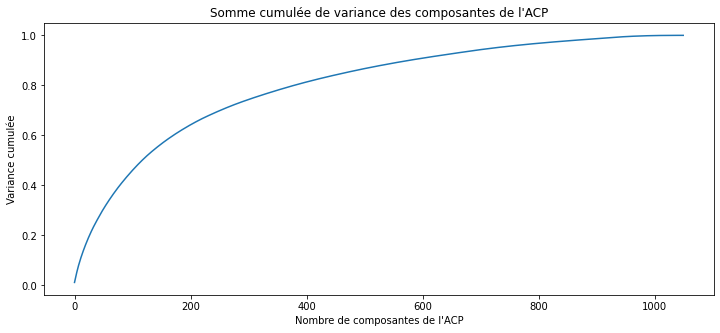

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.plot(list(range(X.shape[0])),
         np.cumsum(pca.explained_variance_ratio_))

In [ ]:
sum_pca = np.cumsum(pca.explained_variance_ratio_)
for counter, value in enumerate(sum_pca):
    if value > 0.80:
        X_reduce = pca.transform(X)[:,:counter]
        break




print('nombre de features : {}, variance : {}'.format(counter+1,np.cumsum(pca.explained_variance_ratio_)[counter]))

nombre de features : 380, variance : 0.8004903210722188


In [ ]:
X_reduce.shape

np.save('data_saved_X_reduce_NLP.csv', X_reduce)

In [ ]:
dict_kmeans_nlp = {}

inertia_nlp = {}

max_clusters_nlp=100


f = IntProgress(min=1, max=max_clusters_nlp) # instantiate the bar
chaine = str(1)+'/'+str(max_clusters_nlp)
g = Text(value=chaine)
display(f) # display the bar
display(g)

for k in range(1,max_clusters_nlp):
    kmeans_nlp = KMeans(n_clusters=k,
                   verbose=0,
                   random_state=0,
                   ).fit(X_reduce)
    inertia_nlp[k] = kmeans_nlp.inertia_
    dict_kmeans_nlp[k] = kmeans_nlp
    f.value = k # signal to increment the progress bar
    g.value =str(k)+'/'+str(max_clusters_nlp)

IntProgress(value=1, min=1)

Text(value='1/100')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


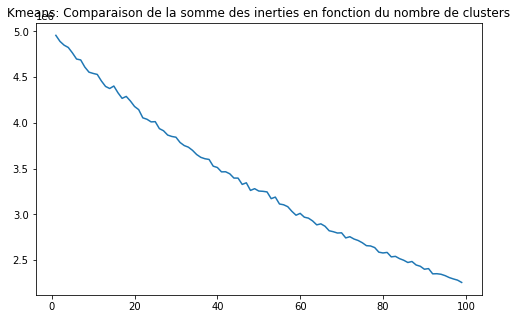

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison de la somme des inerties en fonction du nombre de clusters')
sns.lineplot(list(inertia_nlp.keys()),
             list(inertia_nlp.values())
            )

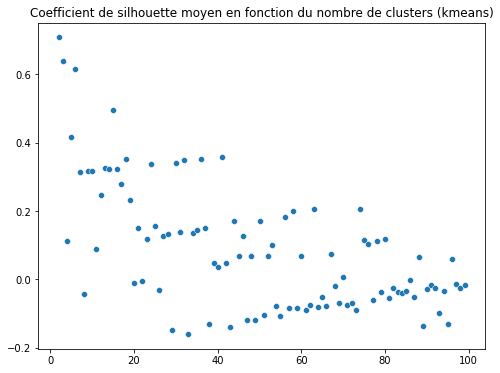

In [ ]:
silhouettes_kmeans_nlp = {}
for i in range(2,max_clusters_nlp):
    silhouettes_kmeans_nlp[i] = silhouette_score(X = X_reduce,
                                             labels= list(dict_kmeans_nlp[i].labels_))

plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(silhouettes_kmeans_nlp.keys()),
               y = list(silhouettes_kmeans_nlp.values()))

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
for key, value in silhouettes_kmeans_nlp.items():
    if value == max(silhouettes_kmeans_nlp.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters_optimal = key

le coefficient de silhouette est maximal pour 2 clusters (score = 0.7084270177927923)


In [ ]:
if nb_clusters_optimal < 5:
    nb_clusters_optimal = 10



dict_kmeans_nlp[nb_clusters_optimal]
data_nlp = data.copy()
data_nlp['label_kmeans'] = dict_kmeans_nlp[nb_clusters_optimal].labels_

In [ ]:
groups_cat_kmeans_nlp = data_nlp[['cat_lvl_1', 'label_kmeans']].groupby('label_kmeans')
val_presence = []
for i in range(1,nb_clusters_optimal):
    val_presence.append(groups_cat_kmeans_nlp.get_group(i).groupby('cat_lvl_1').count().sort_values(by='label_kmeans', ascending=False).iloc[0].tolist()[0]/groups_cat_kmeans_nlp.get_group(i).groupby('cat_lvl_1').count().sum().values.tolist()[0]*100)

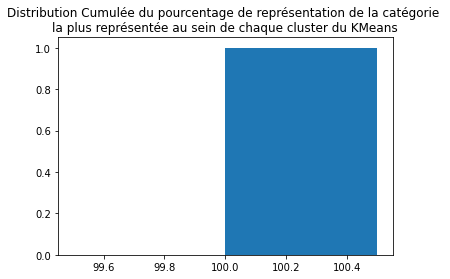

In [ ]:
plt.title('Distribution Cumulée du pourcentage de représentation de la catégorie \nla plus représentée au sein de chaque cluster du KMeans')
plt.hist(val_presence,cumulative=True, density=True, bins=nb_clusters_optimal)
plt.show()

<a name="TSNE"></a>
## **6/Réduction de dimensions TSNE et KMeans** 

In [ ]:
tf = tfidf.fit_transform(data['texte'])
tf_m = pd.DataFrame(tf.toarray(), columns= tfidf.get_feature_names())
tf_m.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,'','m,'re,'s,'smart,'ve,+60c,+70c,",bela",",specifications",...,°f,±3,–,’,“,”,•,….,�,�to
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.060946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


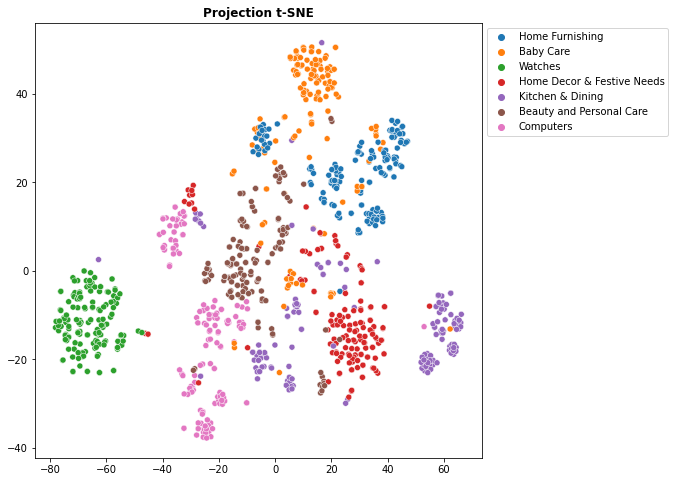

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1500, random_state=42)

tsne_results = tsne.fit_transform(tf_m)
tsne_df = pd.concat([pd.DataFrame(tsne_results), data['cat_lvl_1']], axis=1)
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x=0, y=1, hue=data['cat_lvl_1'], data=tsne_df, sizes=2, ax=ax)
ax.set_title('Projection t-SNE', fontsize=12, weight='bold')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

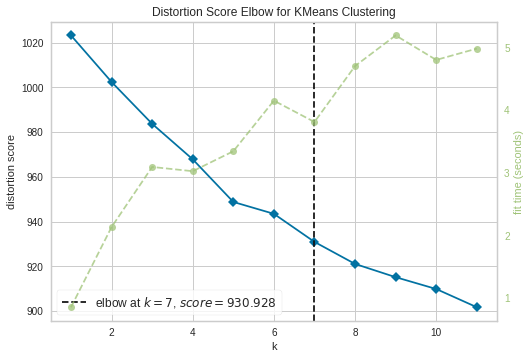

In [ ]:
model = KMeans()


from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(tf_m)  

visualizer.show()   

In [ ]:
# Finding the best number of clusters
silhouettes = []

for n_cluster in range(5, 15):
    cls = KMeans(n_clusters=n_cluster, n_init=50, random_state=7)
    cls.fit(tf_m)
    silhouettes.append(silhouette_score(tf_m, cls.labels_))

KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
cls_bis = KMeans(n_clusters=7, n_init=50, random_state=7)
cls_bis.fit(tf_m)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(range(5, 15), silhouettes, marker='o')
ax.set_ylim(0, 0.2)
ax.set_xticks(range(5, 15))
ax.set_xlabel('n_clusters')
ax.set_ylabel('silhouette score')
ax.grid()
plt.show()

In [ ]:
cls.labels_

In [ ]:
cls_bis.labels_

In [ ]:
tsnekm = np.column_stack((tsne_results, cls_bis.labels_.astype(object)))
tsnekmdf = pd.DataFrame(tsnekm, columns = [0,1,'cls_label'])


fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=0, y=1, hue='cls_label', data=tsnekmdf, palette=sns.color_palette("tab20", 7), legend='full')
ax.set_title('Projection t-SNE', fontsize=12, weight='bold')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [ ]:
# Distribution of the products in each cluster
cross_tab = pd.crosstab(data['cat_lvl_1'], tsnekmdf['cls_label'], normalize='columns')*100
sns.heatmap(cross_tab.round(), annot=True, cmap='RdBu', center=0, cbar=False)
plt.show()

In [ ]:
tf_m

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
np.random.seed()
from sklearn.preprocessing import scale


digits = load_digits()
tf_m = (digits.tf_m)

n_samples, n_features = tf_m.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 1050

print("n_digits: %d, \t n_samples %d, \t n_features %d"
   % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init''         time   inertia   homo   compl   v-meas   ARI     AMI  silhouette')

def bench_k_means(estimator, name, data):
   t0 = time()
   estimator.fit(data)
   print('% 9s %.2fs %i %.3f %.3f %.3f %.3f %.3f %.3f'
      % (name, (time() - t0), estimator.inertia_,
         metrics.homogeneity_score(labels, estimator.labels_),
         metrics.completeness_score(labels, estimator.labels_),
         metrics.v_measure_score(labels, estimator.labels_),
         metrics.adjusted_rand_score(labels, estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_,
            metric='euclidean',
            sample_size=sample_size)))

In [ ]:
import sklearn.metrics as metrics

In [ ]:
tf_m.shape[0]

In [ ]:
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10), name="k-means++", data=tf_m)

<a name="W"></a>
##**8/Traitement de textes : Word Embedding**

Le [Word Embedding](https://blent.ai/word-embedding-nlp-definition/) est une méthode d'encodage qui vise à représenter les mots ou les phrases d’un texte par des vecteurs de nombres réels, décrit dans un modèle vectoriel (ou Vector Space Model).

D'une manière plus simple, chaque mot du vocabulaire V étudié sera représenté par un vecteurs de taille m. Le principe du Word Embedding est de projeter chacun de ces mots dans un espace vectoriel d'une taille fixe N (N étant différent de m). C'est-à-dire quelle que soit la taille du vocabulaire, on devra être capable de projeter un mot dans son espace.

Dans cette partie, nous allons effectuer des incorporations de mots avec Gensim, une boîte à outils très populaire pour le NLP. Nous allons utiliser deux incorporations de mots : Word2vec et FastText.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk, re
from keras.preprocessing.text import Tokenizer
from datetime import datetime
from gensim.models import *
import logging
#from rnn_utils import *
%matplotlib inline

In [ ]:
special_characters = re.compile("[^A-Za-z0-9 ]")
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
def convert_to_sentences(data, tokenizer):
    # First, converting each review into sentences
    # Use NLTK Tokenizer to split review into sentences (punkt tokenizer - english.pickle)
    data = data.lower().replace("<br />", " ")
    data = data.replace("-", " ")
    data = data.replace(".", ". ")
    data = re.sub("  ", " ", data)
    all_sentences = tokenizer.tokenize(data.strip())
    
    # Second, converting each sentence into words
    sentences = []
    for words in all_sentences:
        s = re.sub(special_characters, "", words.lower())
        if (len(s)) > 0:
            sentences.append(s.split())
    
    # Finally, returning a list of sentences (containing words in each sentence)
    return sentences

In [ ]:
sentences_sample = convert_to_sentences(data['texte'][900], tokenizer)
print("Length of formated sentences: {}".format(len(sentences_sample)))

In [ ]:
for i in sentences_sample:
    print(i)

In [ ]:
sentences = []
for review in data['texte']:
    sentences += convert_to_sentences(review, tokenizer)
print("Done for data set.")

In [ ]:
for i in sentences[0:5]:
    print("{}\n".format(i))

Définissons les valeurs du modèle.

- num_feature : la dimension du vecteur de mots. Plus il y a de dimension, meilleure est la représentation, mais cela prendra plus de temps à apprendre. Cependant, puisque nous n'avons pas beaucoup de données, réglons cela sur 50 uniquement (la valeur par défaut est 100).

- min_word_count : tout mot inférieur à ce nombre ne sera pas pris en compte dans l'apprentissage (la valeur par défaut est 5).

- window_size : pour un mot donné, window définit le nombre de mots à considérer à gauche et à droite (la valeur par défaut est 5). Il s'agit de la distance maximale entre le mot actuel et le mot prédit dans une phrase.

- down_sampling : le seuil de configuration des mots de fréquence supérieure qui sont sous-échantillonnés de manière aléatoire, la plage utile est (0, 1e-5).
num_thread : nombre de processus parallèles à exécuter.

- itération : nombre d'itérations (époques) sur le corpus (la valeur par défaut est 5). Cependant, en pratique, il est conseillé d'avoir plus d'itérations pour améliorer les représentations.

- Algorithme d'entraînement : nous choisirons entre le modèle CBOW et le modèle Skip-gram.

- CBOW : fonctionne bien avec un petit ensemble de données, bonne représentation avec des mots/expressions rares.

- Skip-gram : temps d'entraînement plus rapide, précision légèrement meilleure pour les mots fréquents.
Dans ce cas, nous choisirons CBOW qui est la valeur par défaut.

In [ ]:
num_feature = 50
min_word_count = 20
num_thread = 5
window_size = 10
down_sampling = 0.001
iteration = 20

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = word2vec.Word2Vec(sentences, 
                          iter = iteration,
                          size=num_feature, 
                          min_count = min_word_count, 
                          window = window_size, 
                          sample = down_sampling, 
                          workers=num_thread)

### Vérification du Modèle :

In [ ]:
print("Total of words: {}".format(len(model.wv.vocab)))

### Similarité des mots : fonction de Word2Vec

In [ ]:
print(model.wv.similarity('1', '2'))

In [ ]:
print(model.wv.similarity('mug', 'features'))

In [ ]:
model.wv.most_similar('features')

In [ ]:
model.wv.most_similar(positive=['mug','features'],negative=['start'])

###Different from the group

En utilisant la fonction doesnt_match, nous pouvons savoir quel mot n'appartient pas au groupe de mots.

In [ ]:
print(model.wv.doesnt_match("mug features start".split()))

### Représentation des mots sous forme de vecteurs

In [ ]:
print("Vector for word 'features': \n{}".format(model.wv.get_vector('features')))

###Index des mots

In [ ]:
print("At index 15 is the word: {}".format(model.wv.index2word[15]))

In [ ]:
print("Index of word 'start' is: {}".format(model.wv.vocab['start'].index))

<a name="BERT"></a>
##**9/Traitement de textes : BERT**

[BERT](https://datascientest.com/bert-un-outil-de-traitement-du-langage-innovant) est un modèle de type Transformers. Un transformer est un modèle qui fonctionne en effectuant un petit nombre constant d’étapes. À chaque étape, il applique un mécanisme d’attention pour comprendre les relations entre les mots de la phrase, quelles que soient leurs positions respectives.

Dans une phrase,  BERT utilise une nouvelle technique appelée Masked LM (MLM) : il masque aléatoirement des mots dans la phrase, puis il essaie de les prédire. Le masquage signifie que le modèle regarde dans les deux sens et qu’il utilise le contexte complet de la phrase, à gauche et à droite, afin de prédire le mot masqué.


In [ ]:
pip install tokenization

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
data_bert = data['description']
submission=data['description']

In [ ]:
pip install bert-tensorflow

In [ ]:
from bert import tokenization

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
bert_bis = pd.DataFrame(data, columns=["description"])